# Greedy Algorithm Benchmarking (KNN + Felsenstein's Algorithm)

This notebook serves to benchmark VanillaGreedySolver against our missing data imputation function that utilizes uniform bootstrapping and is optimized with Felsenstein's algorithm with bagging.

You can install Cassiopeia by following the guide [here](https://cassiopeia-lineage.readthedocs.io/en/latest/installation.html).

All of our documentation is hosted [here](https://cassiopeia-lineage.readthedocs.io/en/latest/).

In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
import random
import math

import cassiopeia as cas

## Building benchmarking pipeline

The benchmarking pipeline consists of:

1. Simulating a ground truth phylogeny
2. Overlaying data onto this phylogeny
3. Inferring the phylogeny with potentially many algorithms
4. Assessing performance

Setting up necessary variables
- `algorithm` = The algorithms we will compare
- `bd_sim` = Simulates a birth-death process for creating a ground truth tree
- `lt_sim` = Uses a Cas9-based lineage tracing data simulator for overlaying data

In [2]:
algorithms = {
    "Vanilla Greedy": cas.solver.VanillaGreedySolver(),
    "Impute Bagging + Felsenstein": cas.solver.VanillaGreedySolver(),
    # can add more algorithms here
}

bd_sim = cas.sim.BirthDeathFitnessSimulator(
    birth_waiting_distribution=lambda scale: np.random.exponential(scale),
    initial_birth_scale=0.5,
    death_waiting_distribution=lambda: np.random.exponential(1.5),
    mutation_distribution=lambda: 1 if np.random.uniform() < 0.5 else 0,
    fitness_distribution=lambda: np.random.normal(0, 0.5),
    fitness_base=1.3,
    num_extant=400,
    random_seed=17,
)

np.random.seed(seed=None)
lt_sim = cas.sim.Cas9LineageTracingDataSimulator(
    number_of_cassettes=40,
    size_of_cassette=1,
    mutation_rate=0.1,
    state_generating_distribution=lambda: np.random.exponential(1e-5),
    number_of_states=50,
    state_priors=None,
    heritable_silencing_rate=9e-4,
    stochastic_silencing_rate=0.1,
    heritable_missing_data_state=-1,
    stochastic_missing_data_state=-1,
)

In [3]:
# Main Benchmark Code


class Node:
    """Initializes a node with given parameters.

    Arguments:
        name: name of node (only relevant for leaves)
        left: left child (Node)
        right: right child (Node)
        branch_length: length of branch that leads to this node (float)
        branch_id: id of branch that leads to this node (int)
        probs: probability of observed bases beneath this node
                [list of 4 probs for 'ACGT'] (initialized to None)
    """

    def __init__(self, name, left, right, branch_length, branch_id=None):
        self.name = name
        self.left = left
        self.right = right
        self.branch_length = branch_length
        self.branch_id = branch_id
        self.probs = [None for _ in range(52)]


def jcm(b, a, t, u=1.0):
    if a == b:
        return (1 / 51) * (1 + 50 * np.exp((-51 / 50) * u * t))
    else:  # when a =/= b
        return (1 / 51) * (1 - np.exp((-51 / 50) * u * t))


def parse_newick(newick):
    def add_node(name, children):
        # If a ':' is found, there is a name and branch length
        if ":" in name:
            name, branch_length = name.split(":")
            branch_length = float(branch_length)
        # If no ':' is found (ex. root), set branch_length to zero
        else:
            branch_length = 0

        left = children[0] if children else None
        right = children[1] if len(children) > 1 else None
        return Node(name, left, right, branch_length)

    stack = []
    current_node = ("", [])
    for char in newick:
        if char == "(":
            stack.append(current_node)
            current_node = ("", [])
        elif char == ",":
            parent = stack[-1]
            node = add_node(*current_node)
            parent[1].append(node)
            current_node = ("", [])
        elif char == ")":
            parent = stack.pop()
            node = add_node(*current_node)
            parent[1].append(node)
            current_node = parent
        elif char == ";":
            break
        else:
            current_node = (current_node[0] + char, current_node[1])

    return add_node(*current_node)


def postorder_traversal(node):
    result = []
    branch_lengths = []

    def traverse(node, result, branch_lengths):
        if node.left:
            traverse(node.left, result, branch_lengths)
        if node.right:
            traverse(node.right, result, branch_lengths)
        node.branch_id = len(result)
        result.append(node)
        branch_lengths.append(node.branch_length)

    traverse(node, result, branch_lengths)
    return result, branch_lengths


def initialize_topology(newick_string):
    tree = parse_newick(newick_string)
    branch_lengths = []
    ordering, branch_lengths = postorder_traversal(tree)
    bases = list(range(-1, 51))
    branch_probs = [
        np.zeros((len(bases), len(bases)), dtype=float)
        for _ in range(len(branch_lengths) + 1)
    ]
    lengths = np.append(branch_lengths, 0)  # to get the zero length branch
    for branch_id, t in enumerate(lengths):
        for ancestor_base, a in enumerate(bases):
            for descendant_base, b in enumerate(bases):
                branch_probs[branch_id][ancestor_base][descendant_base] = jcm(b, a, t)
    return ordering, branch_probs


def sumLogProbs(a, b):
    if a == float("-inf") and b == float("-inf"):
        return float("-inf")
    if a > b:
        return a + np.log1p(math.exp(b - a))
    else:
        return b + np.log1p(math.exp(a - b))


def likelihood(data, seqlen, ordering, bp):
    bases = list(range(-1, 51))
    pi = 1 / 51
    total_log_prob = float("-inf")

    z = 0
    for char in range(seqlen):
        # print(z)
        z += 1
        # Initialization
        for node in ordering:
            if node.left is None and node.right is None:
                for i in bases:  # range(len(bases)):
                    if bases[i] == data[node.name][char]:
                        node.probs[i] = 0.0
                    else:
                        node.probs[i] = float("-inf")

        # Recursion
        for node in ordering:
            if node.left is not None and node.right is not None:
                for parent_ind in bases:  # range(len(bases)):
                    prob_l = float("-inf")
                    prob_r = float("-inf")
                    for child_ind in bases:  # range(len(bases)):
                        # print(prob_l)
                        prob_l = sumLogProbs(
                            prob_l,
                            node.left.probs[child_ind]
                            + np.log(bp[node.left.branch_id][parent_ind][child_ind]),
                        )
                        # print(prob_r)
                        prob_r = sumLogProbs(
                            prob_r,
                            node.right.probs[child_ind]
                            + np.log(bp[node.right.branch_id][parent_ind][child_ind]),
                        )
                        # print(node.left.probs[child_ind]
                        #     + np.log(bp[node.left.branch_id][parent_ind][child_ind]))
                        # print(node.right.probs[child_ind]
                        #     + np.log(bp[node.right.branch_id][parent_ind][child_ind]))
                    node.probs[parent_ind] = prob_l + prob_r
                    # print(node.probs)
        # Termination
        prob_sum = float("-inf")
        for i in bases:  # range(len(bases)):
            prob_sum = sumLogProbs(prob_sum, np.log(pi) + ordering[-1].probs[i])
        total_log_prob = sumLogProbs(total_log_prob, prob_sum)

    return total_log_prob


def generate_character_matrix(character_matrix, impute):
    character_matrix_copy = character_matrix.copy(deep=True)

    num_row, num_col = character_matrix_copy.shape

    for c in range(num_col):
        cutsite_mut_distr = list(
            filter(lambda x: x != -1, character_matrix[c].tolist())
        )
        for r in range(num_row):
            if random.random() <= impute:
                if character_matrix_copy[c][r] == -1:
                    character_matrix_copy[c][r] = random.choice(cutsite_mut_distr)

    return character_matrix_copy


iterations = 10
algorithm_to_performance_triplets = defaultdict(list)
algorithm_to_performance_rf = defaultdict(list)

for _ in tqdm(range(iterations)):
    ground_truth_tree = bd_sim.simulate_tree()

    np.random.seed(None)
    lt_sim.overlay_data(ground_truth_tree)

    for algorithm_name in tqdm(algorithms.keys()):
        algorithm = algorithms[algorithm_name]
        if algorithm_name == "Vanilla Greedy":
            cm = ground_truth_tree.character_matrix

            reconstructed_tree = cas.data.CassiopeiaTree(
                character_matrix=cm,
                missing_state_indicator=-1,
            )

            algorithm.solve(reconstructed_tree)

            # ground_truth_tree.collapse_mutationless_edges(infer_ancestral_characters = False)
            reconstructed_tree.collapse_mutationless_edges(
                infer_ancestral_characters=True
            )

            rf, rf_max = cas.critique.compare.robinson_foulds(
                ground_truth_tree, reconstructed_tree
            )

            triplets = cas.critique.compare.triplets_correct(
                ground_truth_tree, reconstructed_tree, number_of_trials=500
            )
            algorithm_to_performance_triplets[algorithm_name].append(
                np.mean(list(triplets[0].values()))
            )

            algorithm_to_performance_rf[algorithm_name].append(rf / rf_max)

        elif algorithm_name == "Impute Bagging + Felsenstein":
            cm1 = generate_character_matrix(cm, 0.5)
            cm2 = generate_character_matrix(cm, 0.5)
            cm3 = generate_character_matrix(cm, 0.5)

            highest_likelihood = float("-inf")
            highest_ind = -1
            reconstructed_tree1 = cas.data.CassiopeiaTree(
                character_matrix=cm1,
                missing_state_indicator=-1,
            )
            reconstructed_tree2 = cas.data.CassiopeiaTree(
                character_matrix=cm2,
                missing_state_indicator=-1,
            )
            reconstructed_tree3 = cas.data.CassiopeiaTree(
                character_matrix=cm3,
                missing_state_indicator=-1,
            )
            pos_trees = [reconstructed_tree1, reconstructed_tree2, reconstructed_tree3]

            for ind, tree in enumerate(pos_trees):
                algorithm.solve(tree)
                data = {
                    k: v.tolist()
                    for v, k in zip(
                        tree.character_matrix.values,
                        tree.character_matrix.index,
                    )
                }
                seqlen = len(tree.character_matrix.values[0])
                orderings, probs = initialize_topology(
                    tree.get_newick(record_branch_lengths=True)
                )
                pos_likelihood = likelihood(data, seqlen, orderings, probs)
                if highest_likelihood <= pos_likelihood:
                    highest_likelihood = pos_likelihood
                    highest_ind = ind

            reconstructed_tree = pos_trees[highest_ind]

            # ground_truth_tree.collapse_mutationless_edges(infer_ancestral_characters = False)
            reconstructed_tree.collapse_mutationless_edges(
                infer_ancestral_characters=True
            )

            rf, rf_max = cas.critique.compare.robinson_foulds(
                ground_truth_tree, reconstructed_tree
            )

            triplets = cas.critique.compare.triplets_correct(
                ground_truth_tree, reconstructed_tree, number_of_trials=500
            )
            algorithm_to_performance_triplets[algorithm_name].append(
                np.mean(list(triplets[0].values()))
            )

            algorithm_to_performance_rf[algorithm_name].append(rf / rf_max)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

**Visualising Results**

We will visualize the results by looking at two metrics offered by the Cassiopeia `critique` library:

- Triplets Correct Measure
- Robinson-Foulds Distance

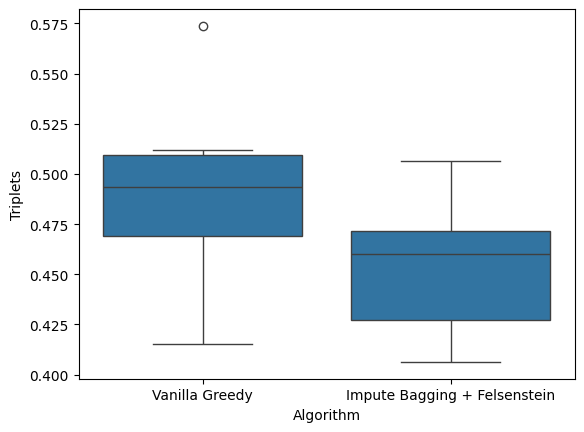

                              count      mean       std       min       25%  \
Algorithm                                                                     
Impute Bagging + Felsenstein   10.0  0.453178  0.031112  0.406333  0.427278   
Vanilla Greedy                 10.0  0.490544  0.042240  0.415111  0.469000   

                                   50%       75%       max  
Algorithm                                                   
Impute Bagging + Felsenstein  0.459889  0.471417  0.506556  
Vanilla Greedy                0.493333  0.509694  0.573778  


In [4]:
# Triplets Correct Measure
algorithm_to_performance_triplets_df = pd.DataFrame(columns=["Algorithm", "Triplets"])
for algorithm in algorithm_to_performance_triplets:
    entries = algorithm_to_performance_triplets[algorithm]
    new_df = pd.DataFrame([algorithm] * len(entries), columns=["Algorithm"])
    new_df["Triplets"] = entries

    algorithm_to_performance_triplets_df = pd.concat([algorithm_to_performance_triplets_df, new_df])

sns.boxplot(data=algorithm_to_performance_triplets_df, x="Algorithm", y="Triplets")
plt.show()

triplets_stats = algorithm_to_performance_triplets_df.groupby("Algorithm")["Triplets"].describe()
print(triplets_stats)

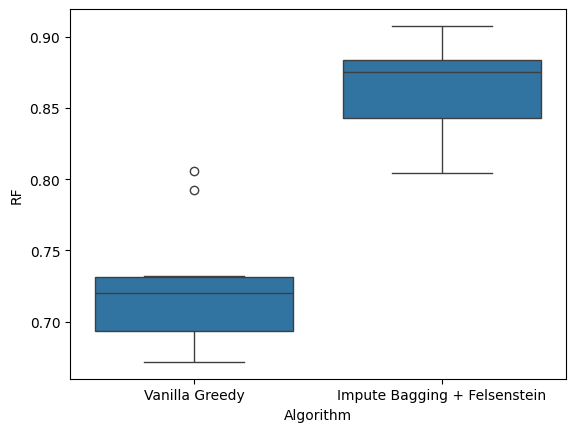

                              count      mean       std       min       25%  \
Algorithm                                                                     
Impute Bagging + Felsenstein   10.0  0.864752  0.031181  0.804173  0.842710   
Vanilla Greedy                 10.0  0.724619  0.044527  0.671743  0.693142   

                                   50%       75%       max  
Algorithm                                                   
Impute Bagging + Felsenstein  0.875139  0.883523  0.907550  
Vanilla Greedy                0.720176  0.731454  0.805654  


In [5]:
# Robinson-Foulds Distance
algorithm_to_performance_rf_df = pd.DataFrame(columns=["Algorithm", "RF"])
for algorithm in algorithm_to_performance_rf:
    entries = algorithm_to_performance_rf[algorithm]
    new_df = pd.DataFrame([algorithm] * len(entries), columns=["Algorithm"])
    new_df["RF"] = entries

    algorithm_to_performance_rf_df = pd.concat([algorithm_to_performance_rf_df, new_df])

sns.boxplot(data=algorithm_to_performance_rf_df, x="Algorithm", y="RF")
plt.show()

rf_stats = algorithm_to_performance_rf_df.groupby("Algorithm")["RF"].describe()
print(rf_stats)